### Generating Noisy points amounting to a line and a circle

<Axes: >

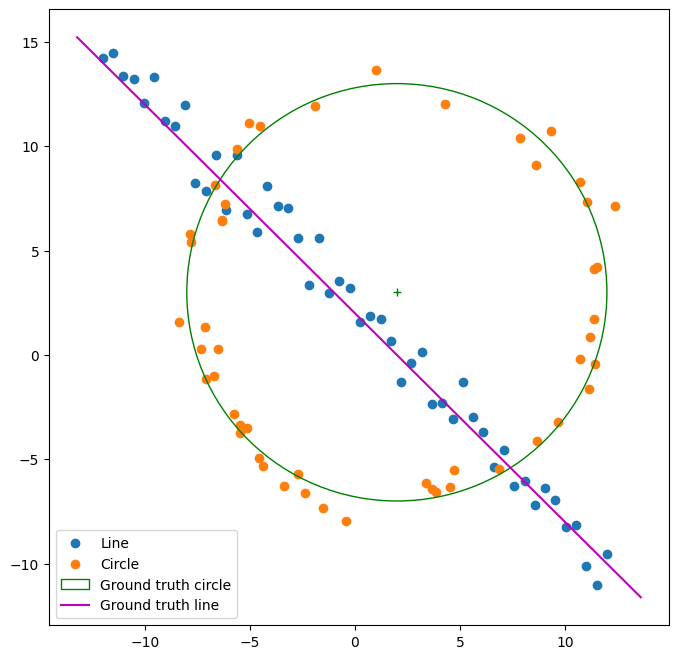

In [1]:
# Generating noisy point set

from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
#import tikzplotlib

# Set random seed
np.random.seed(0)

# Constants
N = 100
half_n = N // 2

# Parameters
r = 10
x0_gt, y0_gt = 2, 3
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s, m, b = 1, -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

# Plotting
def plot_all(separate = True):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if separate:
        ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
        ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
    else:
        ax.scatter(X[:, 0], X[:, 1], label='Point Set')

    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, '+', color='g')

    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = m * x_ + b
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    return ax

plot_all()

### Distance Calculations

In [2]:
# Helper function to calculate the normal distance from a point to a line
def calculate_distance(point, a, b, d):
    return abs(a * point[0] + b * point[1] + d) / np.sqrt(a**2 + b**2)

# Helper function to calculate the distance from a point to the circle
def calculate_circle_distance(point, x0, y0, r):
    return abs(np.sqrt((point[0] - x0)**2 + (point[1] - y0)**2) - r)

### RANSAC Functions

In [3]:
# RANSAC for line fitting
def ransac_line_fitting(X, num_iterations=100, distance_threshold=1.0, consensus_ratio=0.6):
    best_model = None
    max_inliers = 0
    n = len(X)

    for _ in range(num_iterations):
        # Randomly select two points to define a line
        idx = np.random.choice(n, 2, replace=False)
        p1, p2 = X[idx[0]], X[idx[1]]

        # Compute the line parameters [a, b, d] where ax + by + d = 0 and [a, b] is the normal vector
        a = p2[1] - p1[1]  # change in y
        b = p1[0] - p2[0]  # change in x
        norm = np.sqrt(a**2 + b**2)
        a, b = a / norm, b / norm  # Ensure unit normal vector
        d = -(a * p1[0] + b * p1[1])

        # Compute inliers (points whose distance to the line is below the threshold)
        inliers = []
        for point in X:
            dist = calculate_distance(point, a, b, d)
            if dist < distance_threshold:
                inliers.append(point)

        # If the number of inliers is the largest so far, update the best model
        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_model = (a, b, d)

        # Stop early if a consensus of points is reached
        if max_inliers > consensus_ratio * n:
            break

    return best_model, max_inliers



# RANSAC for circle fitting
def ransac_circle_fitting(X, num_iterations=100, distance_threshold=1.1, consensus_ratio=0.5):
    best_model = None
    max_inliers = 0
    n = len(X)

    for _ in range(num_iterations):
        # Randomly select three points to define a circle
        idx = np.random.choice(n, 3, replace=False)
        p1, p2, p3 = X[idx[0]], X[idx[1]], X[idx[2]]

        # Compute the circle parameters (x0, y0, r) using the three points
        A = np.array([
            [p1[0], p1[1], 1],
            [p2[0], p2[1], 1],
            [p3[0], p3[1], 1]
        ])
        B = np.array([
            [-(p1[0]**2 + p1[1]**2)],
            [-(p2[0]**2 + p2[1]**2)],
            [-(p3[0]**2 + p3[1]**2)]
        ])

        if np.linalg.det(A) == 0:
            continue  # Points are collinear; skip this iteration

        x0, y0, _ = np.linalg.solve(A, B).flatten()
        x0, y0 = -x0 / 2, -y0 / 2  # Circle center

        r = np.sqrt(x0**2 + y0**2 - np.mean(B))

        # Compute inliers (points close enough to the circle's circumference)
        inliers = []
        for point in X:
            dist = calculate_circle_distance(point, x0, y0, r)
            if dist < distance_threshold:
                inliers.append(point)

        # If the number of inliers is the largest so far, update the best model
        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_model = (x0, y0, r)

        # Stop early if a consensus of points is reached
        if max_inliers > consensus_ratio * n:
            break

    return best_model, max_inliers

### Performing RANSAC Fitting

In [129]:
# Perform RANSAC line fitting
best_line_model, max_inliers = ransac_line_fitting(X, num_iterations=100, distance_threshold=1.3, consensus_ratio=0.5)

# Perform RANSAC circle fitting
best_circle_model, max_inliers_circle = ransac_circle_fitting(X, num_iterations=100, distance_threshold=1.2, consensus_ratio=0.6)

### Plot Results

#### Plot Line Model

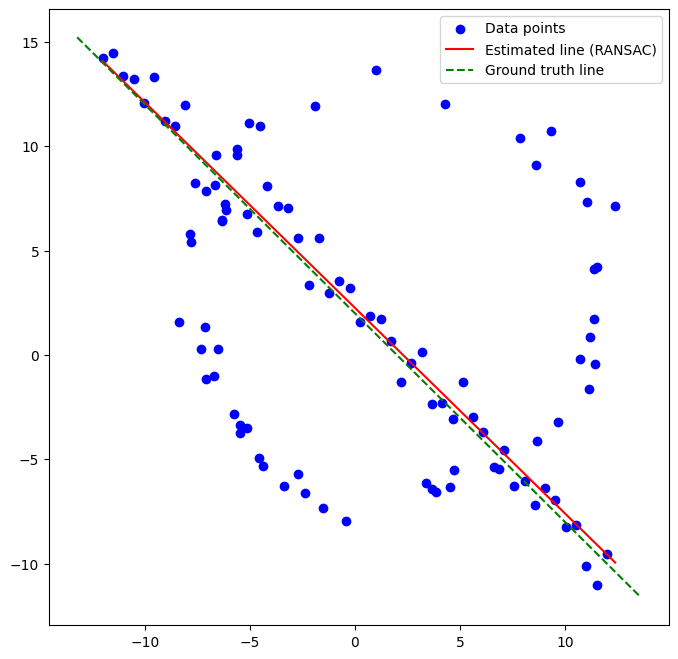

In [130]:
# Plot results
def plot_ransac_line(best_model, X):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the points
    ax.scatter(X[:, 0], X[:, 1], label='Data points', color='blue')

    # Plot the inliers
    if best_line_model is not None:
        a, b, d = best_line_model
        x_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
        y_vals = -(a * x_vals + d) / b  # Line equation: ax + by + d = 0
        ax.plot(x_vals, y_vals, color='red', label='Estimated line (RANSAC)')
    
    # Ground truth line for comparison
    m, b = -1, 2
    x_min, x_max = ax.get_xlim()
    x_gt = np.array([x_min, x_max])
    y_gt = m * x_gt + b
    ax.plot(x_gt, y_gt, color='green', linestyle='--', label='Ground truth line')

    plt.legend()
    plt.show()

plot_ransac_line(best_line_model, X)

#### Plot Circle Model

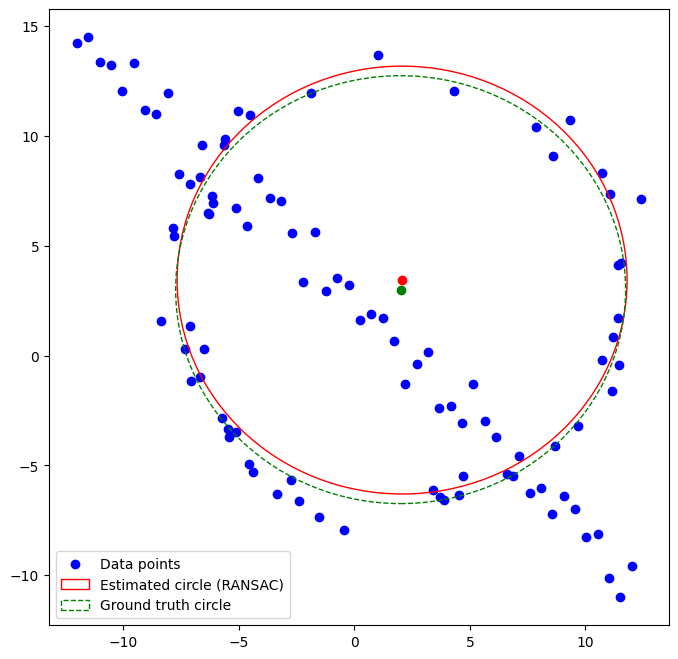

In [131]:
# Plot results
def plot_ransac_circle(best_model, X):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the points
    ax.scatter(X[:, 0], X[:, 1], label='Data points', color='blue')

    # Plot the inliers
    if best_model is not None:
        x0, y0, r = best_model
        circle = plt.Circle((x0, y0), r, color='red', fill=False, label='Estimated circle (RANSAC)')
        ax.add_patch(circle)
        ax.plot(x0, y0, 'o', color='red')

    # Ground truth circle for comparison
    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='green', linestyle='--', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, 'o', color='green')

    plt.legend()
    plt.show()

plot_ransac_circle(best_circle_model, X)

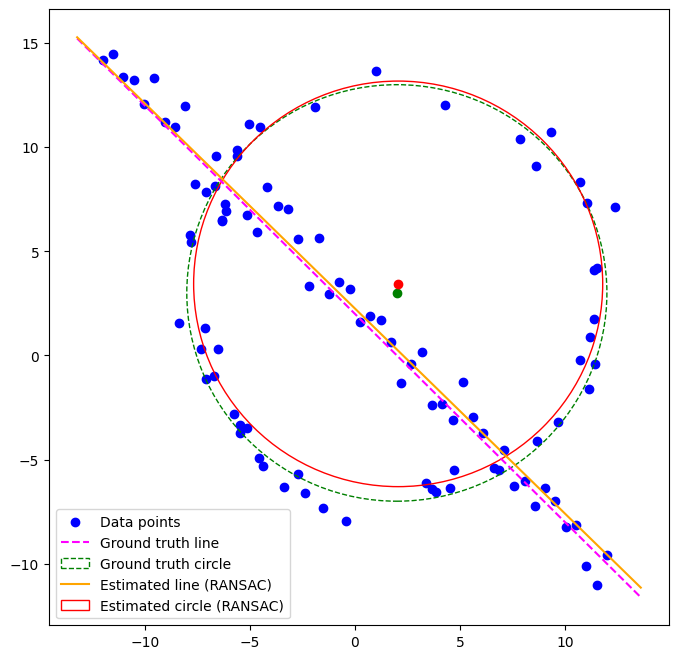

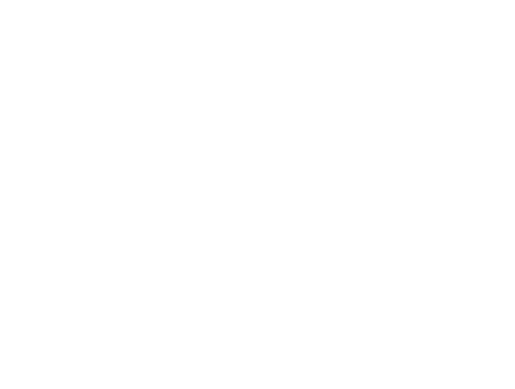

In [134]:
def plot_ransac_results(best_line_model, best_circle_model, X):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the data points
    ax.scatter(X[:, 0], X[:, 1], label='Data points', color='blue')

    # Ground truth line
    m, b = -1, 2
    x_min, x_max = ax.get_xlim()
    x_gt = np.array([x_min, x_max])
    y_gt = m * x_gt + b
    ax.plot(x_gt, y_gt, color='magenta', linestyle='--', label='Ground truth line')

    # Ground truth circle
    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='green', fill=False, linestyle='--', label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, 'o', color='green')

    # RANSAC estimated line
    if best_line_model is not None:
        a, b, d = best_line_model
        x_ransac = np.array([x_min, x_max])
        y_ransac = -(a * x_ransac + d) / b
        ax.plot(x_ransac, y_ransac, color='orange', label='Estimated line (RANSAC)')

    # RANSAC estimated circle
    if best_circle_model is not None:
        x0_est, y0_est, r_est = best_circle_model
        circle_ransac = plt.Circle((x0_est, y0_est), r_est, color='red', fill=False, label='Estimated circle (RANSAC)')
        ax.add_patch(circle_ransac)
        ax.plot(x0_est, y0_est, 'o', color='red')

    plt.legend()
    plt.show()
    plt.axis('off')


plot_ransac_results(best_line_model, best_circle_model, X)